In [49]:
# # Simulation of overlapping round Gaussian beams to achieve homogeneous intensity
# # This code simulates placing identical rotationally symmetric Gaussian beams on
# # either a square grid or a hexagonal (staggered) grid and evaluates the resulting
# # intensity uniformity for a set of grid spacings expressed as fractions of the beam FWHM.
# #
# # You can change `fwhm_pixels` to match your measured beam FWHM (in pixels or arbitrary units).
# # The code outputs metric tables and displays intensity maps for the best spacings
# # for square and hex grids.

# import numpy as np
# import matplotlib.pyplot as plt

# from math import sqrt, pi

# # --- Parameters (change these to match your beam / desired resolution) ---
# fwhm_pixels = 60.0   # approximate beam FWHM (in pixels); adjust to your measurement
# sigma = fwhm_pixels / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # Gaussian sigma
# beam_extent = int(6 * sigma)  # extent for single-beam kernel (half-size)
# canvas_size = 512  # simulation canvas size in pixels
# center = canvas_size // 2

# # Spacing fractions to test (fractions of FWHM)
# fractions = np.linspace(0.30, 1.00, 15)  # 0.3 to 1.0 of FWHM

# def gaussian_2d(size, sigma):
#     """Return a centered Gaussian kernel of given half-size and sigma."""
#     ax = np.arange(-size, size+1)
#     xx, yy = np.meshgrid(ax, ax)
#     g = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
#     return g / g.max()

# # single-beam kernel
# kern = gaussian_2d(beam_extent, sigma)
# kern_size = kern.shape[0]

# def make_grid_positions(pattern, spacing_px, canvas_size, margin=0):
#     """Return a list of (x,y) center positions for beams on a canvas."""
#     positions = []
#     if pattern == 'square':
#         # square grid
#         xs = np.arange(margin, canvas_size-margin, spacing_px)
#         ys = np.arange(margin, canvas_size-margin, spacing_px)
#         for x in xs:
#             for y in ys:
#                 positions.append((int(round(x)), int(round(y))))
#     elif pattern == 'hex':
#         # hexagonal (staggered) grid: rows offset by spacing/2, vertical spacing = spacing * sqrt(3)/2
#         dx = spacing_px
#         dy = spacing_px * np.sqrt(3) / 2.0
#         y = margin
#         row = 0
#         while y < canvas_size - margin:
#             x_offset = 0.0 if row % 2 == 0 else dx/2.0
#             x = margin + x_offset
#             while x < canvas_size - margin:
#                 positions.append((int(round(x)), int(round(y))))
#                 x += dx
#             row += 1
#             y += dy
#     return positions

# def render_map(positions, kern, canvas_size):
#     """Render summed intensity map for beams centered at positions."""
#     canvas = np.zeros((canvas_size, canvas_size), dtype=float)
#     k = kern
#     ks = kern.shape[0] // 2
#     for (cx, cy) in positions:
#         x0 = cx - ks
#         y0 = cy - ks
#         x1 = x0 + k.shape[0]
#         y1 = y0 + k.shape[1]
#         # determine overlap region with canvas
#         ix0, iy0 = max(0, x0), max(0, y0)
#         ix1, iy1 = min(canvas_size, x1), min(canvas_size, y1)
#         kx0, ky0 = ix0 - x0, iy0 - y0
#         kx1, ky1 = kx0 + (ix1-ix0), ky0 + (iy1-iy0)
#         canvas[iy0:iy1, ix0:ix1] += k[ky0:ky1, kx0:kx1]
#     return canvas

# # Evaluate spacings for both patterns
# results = []
# for pattern in ('square', 'hex'):
#     for frac in fractions:
#         spacing_px = frac * fwhm_pixels
#         positions = make_grid_positions(pattern, spacing_px, canvas_size, margin=beam_extent+2)
#         canvas = render_map(positions, kern, canvas_size)
#         # evaluate uniformity in a central circular ROI (avoid edge effects)
#         y, x = np.ogrid[:canvas_size, :canvas_size]
#         r = np.sqrt((x-center)**2 + (y-center)**2)
#         roi_mask = r <= (canvas_size/2.5)  # central region
#         roi = canvas[roi_mask]
#         mean = roi.mean()
#         std = roi.std()
#         peak = roi.max()
#         trough = roi.min()
#         # metrics: coefficient of variation and peak-to-trough relative spread
#         cv = std / mean
#         p2t = (peak - trough) / mean
#         results.append({
#             'pattern': pattern,
#             'fraction': frac,
#             'spacing_px': spacing_px,
#             'mean': mean,
#             'std': std,
#             'cv': cv,
#             'p2t': p2t,
#             'num_beams': len(positions)
#         })

# # pick best (lowest CV) for each pattern
# best_square = min([r for r in results if r['pattern']=='square'], key=lambda x: x['cv'])
# best_hex = min([r for r in results if r['pattern']=='hex'], key=lambda x: x['cv'])

# best_square, best_hex

# # Show numeric summary table
# import pandas as pd
# df = pd.DataFrame(results).sort_values(['pattern', 'fraction'])
# df_display = df[['pattern', 'fraction', 'spacing_px', 'num_beams', 'mean', 'std', 'cv', 'p2t']]
# # display using simple print (the UI will also show the dataframe nicely)
# print("Summary (sorted):")
# print(df_display.head(20).to_string(index=False))

# # Display two best intensity maps side-by-side
# canvas_sq = render_map(make_grid_positions('square', best_square['spacing_px'], canvas_size, margin=beam_extent+2), kern, canvas_size)
# canvas_hex = render_map(make_grid_positions('hex', best_hex['spacing_px'], canvas_size, margin=beam_extent+2), kern, canvas_size)

# # Normalize for visualization
# canvas_sq_n = canvas_sq / np.mean(canvas_sq)
# canvas_hex_n = canvas_hex / np.mean(canvas_hex)

# # Plot square best
# plt.figure(figsize=(6,5))
# plt


In [50]:
# # Creating plots and simulations of a rotationally symmetric beam (super-Gaussian family),
# # then simulating overlapping spots on a target using square and hexagonal grids.
# # All distances in micrometers (µm).

# import numpy as np
# import matplotlib.pyplot as plt

# # --- beam definitions ---
# def super_gaussian_2d(x, y, w=30.0, n=8):
#     """Rotationally symmetric super-Gaussian intensity profile.
#     I(r) = exp(-(r/w)**n) normalized so peak = 1.
#     w: characteristic radius [µm], n: order (n=2 => Gaussian)."""
#     r = np.sqrt(x**2 + y**2)
#     I = np.exp(-(r / w)**n)
#     return I / I.max()

# # grid for plotting
# extent = 120  # half-range (µm)
# res = 0.5     # grid spacing (µm)
# xs = np.arange(-extent, extent+res, res)
# ys = np.arange(-extent, extent+res, res)
# X, Y = np.meshgrid(xs, ys)

# # Example beams
# w = 30.0   # µm (characteristic radius)
# beams = {
#     "Gaussian (n=2)": super_gaussian_2d(X, Y, w=w, n=2),
#     "Super-Gaussian (n=8)": super_gaussian_2d(X, Y, w=w, n=8),
#     "Very flat (n=20)": super_gaussian_2d(X, Y, w=w, n=20),
# }

# # Plot 2D maps and central cuts for each beam type
# for title, I in beams.items():
#     fig = plt.figure(figsize=(10,4))
#     ax1 = fig.add_subplot(1,2,1)
#     im = ax1.imshow(I, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
#     ax1.set_title(f"{title} — 2D intensity (normalized)")
#     ax1.set_xlabel("x (µm)"); ax1.set_ylabel("y (µm)")
#     plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    
#     ax2 = fig.add_subplot(1,2,2)
#     center_idx = len(xs)//2
#     ax2.plot(xs, I[center_idx,:], label="x-cut (y=0)")
#     ax2.plot(ys, I[:,center_idx], linestyle='--', label="y-cut (x=0)")
#     ax2.set_title("Central cuts")
#     ax2.set_xlabel("position (µm)"); ax2.set_ylabel("normalized intensity")
#     ax2.legend()
#     plt.tight_layout()
#     plt.show()

# # --- Overlap simulation ---
# def generate_grid_centers(spacing, pattern="square", bounds=extent):
#     """Return centers for either 'square' or 'hex' grid covering [-bounds,bounds] box."""
#     s = spacing
#     centers = []
#     if pattern == "square":
#         xs_g = np.arange(-bounds- s, bounds + s, s)
#         ys_g = np.arange(-bounds- s, bounds + s, s)
#         for xi in xs_g:
#             for yi in ys_g:
#                 centers.append((xi, yi))
#     elif pattern == "hex":
#         dx = s
#         dy = s * np.sqrt(3)/2
#         xs_g = np.arange(-bounds- dx, bounds + dx, dx)
#         ys_g = np.arange(-bounds- dy, bounds + dy, dy)
#         for j, yi in enumerate(ys_g):
#             xshift = 0.5*dx if (j % 2)==0 else 0.0
#             for xi in xs_g:
#                 centers.append((xi + xshift, yi))
#     return np.array(centers)

# def composite_intensity(centers, beam_func, X, Y):
#     I = np.zeros_like(X)
#     for cx, cy in centers:
#         I += beam_func(X - cx, Y - cy)
#     # normalize to peak = 1 (useful to compare shapes)
#     return I / I.max()

# # Compare spacings and grid patterns
# spacings = [30, 40, 50, 60]  # µm
# patterns = ["square", "hex"]

# results = []
# for pat in patterns:
#     for s in spacings:
#         centers = generate_grid_centers(s, pattern=pat, bounds=extent)
#         Icomp = composite_intensity(centers, lambda x,y: super_gaussian_2d(x,y,w=w,n=8), X, Y)
#         # Compute homogeneity metric in a central region to avoid edge effects:
#         central_mask = (np.abs(X) <= 60) & (np.abs(Y) <= 60)  # central 120x120 µm region
#         vals = Icomp[central_mask]
#         mean = vals.mean()
#         std = vals.std()
#         cov = std/mean if mean>0 else np.nan
#         results.append({"pattern": pat, "spacing": s, "mean": mean, "std": std, "cov": cov, "Icomp": Icomp})

# # Display best/worst cases
# import pandas as pd
# df = pd.DataFrame([{"pattern": r["pattern"], "spacing": r["spacing"], "mean": r["mean"], "std": r["std"], "cov": r["cov"]} for r in results])
# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("Overlap homogeneity table", df.sort_values(["pattern","spacing"]))

# # Show composite maps for representative cases and histograms
# for r in results:
#     if r["spacing"] in (40, 60) and r["pattern"] == "hex":
#         Icomp = r["Icomp"]
#         fig, ax = plt.subplots(1,2, figsize=(10,4))
#         ax[0].imshow(Icomp, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
#         ax[0].set_title(f"{r['pattern'].capitalize()} grid, spacing {r['spacing']} µm — composite (norm)")
#         ax[0].set_xlabel("x (µm)"); ax[0].set_ylabel("y (µm)")
#         ax[1].hist(Icomp[(np.abs(X)<=60)&(np.abs(Y)<=60)].ravel(), bins=60)
#         ax[1].set_title("Fluence distribution in central region")
#         ax[1].set_xlabel("normalized fluence"); ax[1].set_ylabel("counts")
#         plt.tight_layout()
#         plt.show()

# # Print numeric summary sorted by cov (lower = more uniform)
# print("\nNumeric summary (lower CoV => better uniformity):\n")
# print(df.sort_values("cov").to_string(index=False))


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
def super_gaussian_2d(x, y, w=40.0, n=8):
    """Rotationally symmetric super-Gaussian intensity profile.
    I(r) = exp[-(r/w)^n] normalized so peak = 1.
    w: characteristic radius [µm], n: order (n=2 => Gaussian)
    general gaussian: A*exp[-(x^2)/(2 sigma^2)]
    => for radial symmetry replace x^2 with r^2 = x^2 + y^2
    => generalize exponent with power n instead ^2
    => for higher n sigma is no longer the std => width paramter w"""
    r = np.sqrt(x**2 + y**2)
    I = np.exp(-(r / w)**n)
    return I / I.max()


# grid for plotting
extent = 100        # half-range (µm)
step_size = 0.5     # grid spacing (µm)
xs = np.arange(-extent, extent, step_size)
ys = np.arange(-extent, extent, step_size)
w=45
X, Y = np.meshgrid(xs, ys, sparse=False) # spares saves memmry by removing duplicates, which can by indexed automatically
# returns 2 Arrys [[-80.  -79.5 -79.  -78.5 -78.
#                   -74.  -73.5 -73.  -72.5 -72.]]
#                 [[-79.5]
#                  [-79. ]
#                  [-78.5]]]
# as visible each array only hase 1 column/row, because the shape is symmetric
print(X.shape,Y.shape)

n_values = [2, 4, 6, 8]
peak_shapes = {
    f'Gaussian (n={n})': super_gaussian_2d(X, Y, w, n=n)   # key=i, value=function result
    for n in n_values
}

(400, 400) (400, 400)


### plot the peak shapes

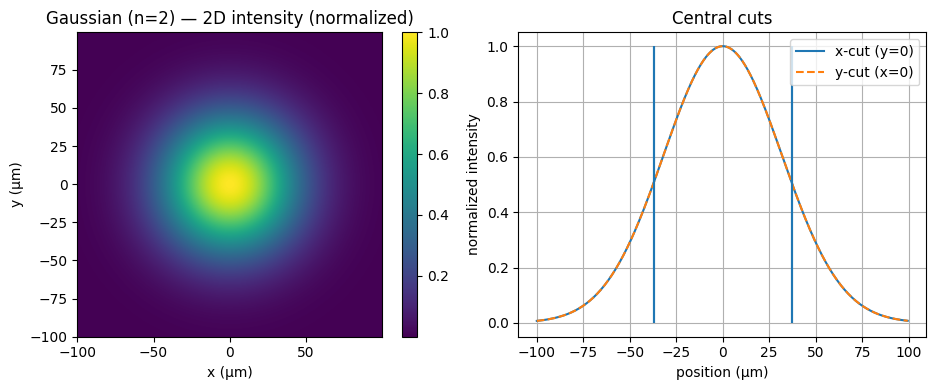

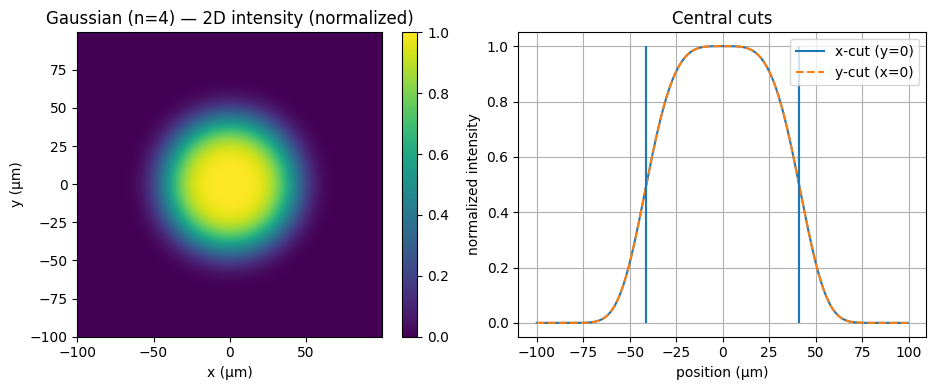

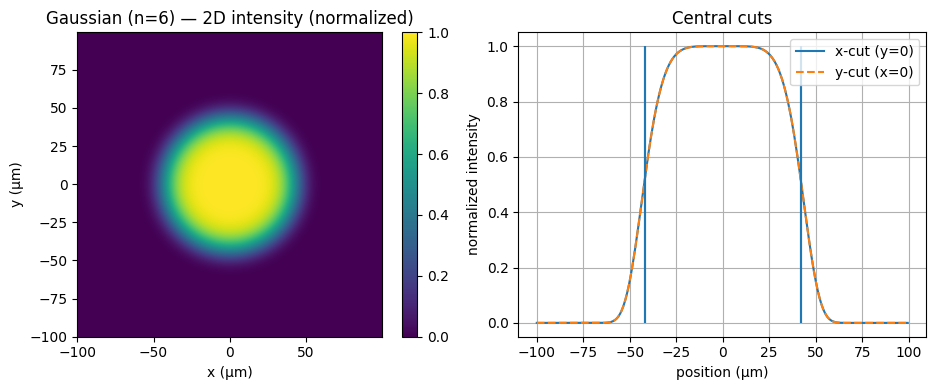

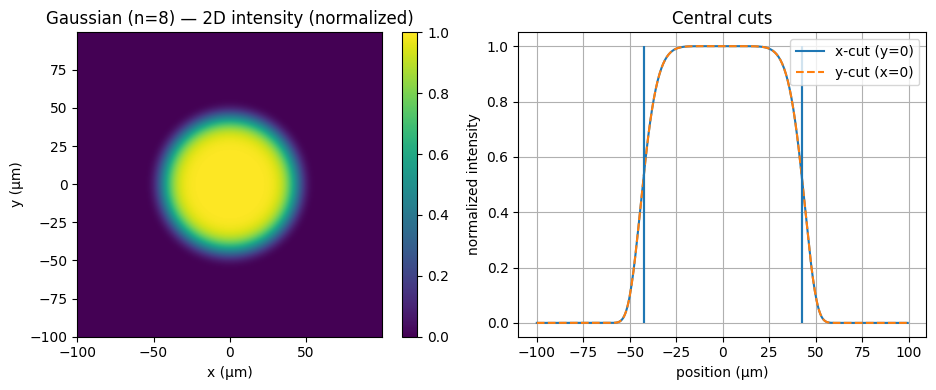

In [3]:
def get_FWHM_super_gaussion(peak, xs, ys):
    # FWHM = 2w(ln2)^(1/n) for gaussians
    half_max = peak.max() / 2

    # Slice through center row for x-direction
    center_y = peak.shape[0] // 2
    profile_x = peak[center_y, :]
    indices_x = np.where(profile_x >= half_max)[0]  # gets indices of all values larger half_max
    fwhm_x = xs[indices_x[-1]] - xs[indices_x[0]]   # get the actual width of those indices in µm and not indices

    # Slice through center column for y-direction
    center_x = peak.shape[1] // 2
    profile_y = peak[:, center_x]
    indices_y = np.where(profile_y >= half_max)[0]
    fwhm_y = ys[indices_y[-1]] - ys[indices_y[0]]
    
    fwhm_x_coords = xs[indices_x[0]], xs[indices_x[-1]]  # left & right edges
    fwhm_y_coords = ys[indices_y[0]], ys[indices_y[-1]]  # bottom & top edges

    return fwhm_x, fwhm_y, fwhm_x_coords, fwhm_y_coords
    
    
# Plot 2D maps and central cuts for each beam type
for name, peak in peak_shapes.items():
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1)
    im = ax1.imshow(peak, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]]) # indexes all elements of the meshgrid and creates an array the size of the plot + lower sets (0,0) bottom-left
    ax1.set_title(f"{name} — 2D intensity (normalized)")
    ax1.set_xlabel("x (µm)")
    ax1.set_ylabel("y (µm)")
    # plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    plt.colorbar(im, ax=ax1, fraction=0.05, pad=0.05)
    
    # plot 1D peak profile
    ax2 = fig.add_subplot(1,2,2)
    center_idx = len(xs)//2
    ax2.plot(xs, peak[center_idx,:], label="x-cut (y=0)")
    ax2.plot(ys, peak[:,center_idx], linestyle='--', label="y-cut (x=0)")

    fwhm_x, fwhm_y, fwhm_x_coords, fwhm_y_coords = get_FWHM_super_gaussion(peak, xs, ys)
    ax2.vlines([fwhm_x_coords, fwhm_y_coords], 0,1)
    ax2.set_title("Central cuts")
    ax2.set_xlabel("position (µm)")
    ax2.set_ylabel("normalized intensity")
    ax2.grid()
    ax2.legend()
    plt.tight_layout()
    plt.show()

n = 6 gives the closest result to the data of Carsten Hellinger
=> is used in the following overlapping simulation

### Overlap simulation

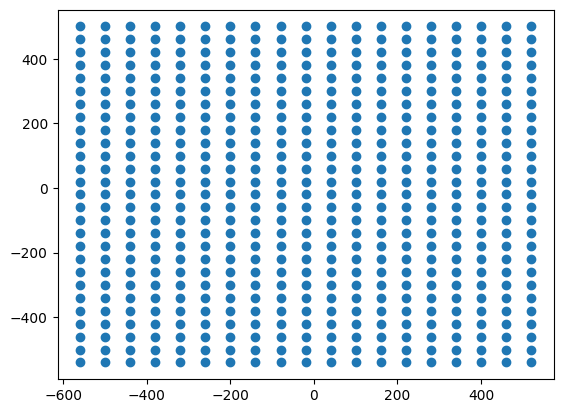

In [25]:
# create new beam profile
# -> for better reafability only 
# using the same parameters as the previous plots
w = 45
n = 6

grid_size = 500    # half-range (µm) + and -
grid_res = 1.0     # resolution in µm
spacing_x = 60     # shift between spots in µm
spacing_y = 40     # shift between spots in µm

# create grid in µm dimensions in which the overlapping is simulated
xs = np.arange(-grid_size, grid_size, grid_res)
ys = np.arange(-grid_size, grid_size, grid_res)
X, Y = np.meshgrid(xs, ys)

# create an array of the centers of spots to be overlappt
# => creates map of the peak coordinates
def get_positions_grid(spacing_x, spacing_y, pattern="square", bounds=grid_size):
    centers = []
    if pattern == "square":
        xs_grid = np.arange(-bounds - spacing_x, bounds + spacing_x, spacing_x)
        ys_grid = np.arange(-bounds - spacing_y, bounds + spacing_y, spacing_y)
        for xi in xs_grid:
            for yi in ys_grid:
                centers.append((xi, yi))
                
    elif pattern == "hex":
        dx = spacing_x
        dy = spacing_x * np.sqrt(3)/2
        ys_grid = np.arange(-bounds - dy, bounds + dy, dy)
        xs_grid = np.arange(-bounds - dx, bounds + dx, dx)
        for j, yi in enumerate(ys_grid):
            xshift = 0.5*dx if (j % 2)==0 else 0.0
            for xi in xs_grid:
                centers.append((xi + xshift, yi))
                
    return np.array(centers)

position_grid = get_positions_grid(spacing_x, spacing_y, pattern="square", bounds=grid_size)

fig, ax = plt.subplots()
ax.scatter(position_grid[:,0], position_grid[:,1])
plt.show()

now that the locations of the spots are defined, the actual peak shap can be overlapped by summing up all intensity values for each location

In [ ]:
def overlapped_intensity(centers, beam_func):
    I = np.zeros_like(X)
    for cx, cy in centers:
        # print(cx, cy)
        I += beam_func(X - cx, Y - cy)  # to shift the peak to be at the desired position
    return I

beam_func = super_gaussian_2d(X, Y, w, n=n)
I = overlapped_intensity(position_grid, super_gaussian_2d)


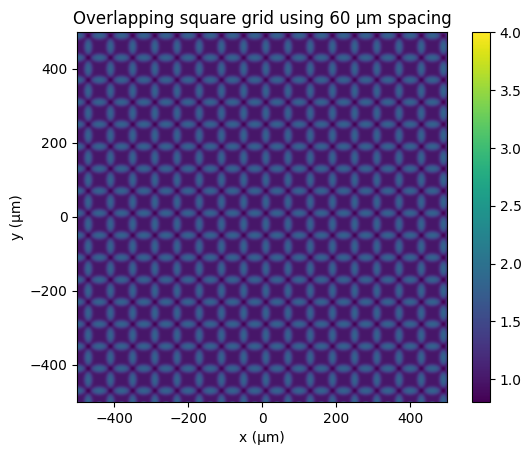

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(I, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_title(f'Overlapping square grid using {spacing_x} µm x and {spacing_y} µm y spacing')
fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05)
plt.savefig('square_grid_60.png')
plt.show()

In [6]:
def generate_grid_centers(spacing, pattern="square", bounds=extent):
    """Return centers for either 'square' or 'hex' grid covering [-bounds,bounds] box."""
    s = spacing
    centers = []
    if pattern == "square":
        xs_g = np.arange(-bounds- s, bounds + s, s)
        ys_g = np.arange(-bounds- s, bounds + s, s)
        for xi in xs_g:
            for yi in ys_g:
                centers.append((xi, yi))
    elif pattern == "hex":
        dx = s
        dy = s * np.sqrt(3)/2
        xs_g = np.arange(-bounds- dx, bounds + dx, dx)
        ys_g = np.arange(-bounds- dy, bounds + dy, dy)
        for j, yi in enumerate(ys_g):
            xshift = 0.5*dx if (j % 2)==0 else 0.0
            for xi in xs_g:
                centers.append((xi + xshift, yi))
    return np.array(centers)

def composite_intensity(centers, beam_func, X, Y):
    I = np.zeros_like(X)
    for cx, cy in centers:
        I += beam_func(X - cx, Y - cy)
    # normalize to peak = 1 (useful to compare shapes)
    return I / I.max()

# Compare spacings and grid patterns
spacings = [30, 40, 50, 60]  # µm
patterns = ["square", "hex"]

results = []
for pat in patterns:
    for s in spacings:
        centers = generate_grid_centers(s, pattern=pat, bounds=extent)
        Icomp = composite_intensity(centers, lambda x,y: super_gaussian_2d(x,y,w=w,n=6), X, Y)
        # Compute homogeneity metric in a central region to avoid edge effects:
        central_mask = (np.abs(X) <= 60) & (np.abs(Y) <= 60)  # central 120x120 µm region
        vals = Icomp[central_mask]
        mean = vals.mean()
        std = vals.std()
        cov = std/mean if mean>0 else np.nan
        results.append({"pattern": pat, "spacing": s, "mean": mean, "std": std, "cov": cov, "Icomp": Icomp})

In [7]:
df = pd.DataFrame([{"pattern": r["pattern"], "spacing": r["spacing"], "mean": r["mean"], "std": r["std"], "cov": r["cov"]} for r in results])
df

,pattern,spacing,mean,std,cov
0,square,30,0.851001,0.022597,0.026554
1,square,40,0.669346,0.013789,0.020601
2,square,50,0.506634,0.083130,0.164084
3,square,60,0.394000,0.063108,0.160173
4,hex,30,0.970461,0.011628,0.011982
5,hex,40,0.731491,0.037613,0.051419
6,hex,50,0.693446,0.063383,0.091403
7,hex,60,0.440406,0.097502,0.221392


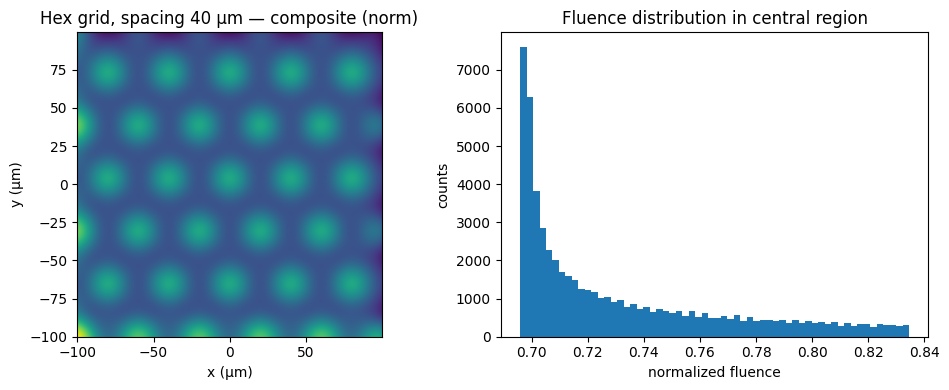

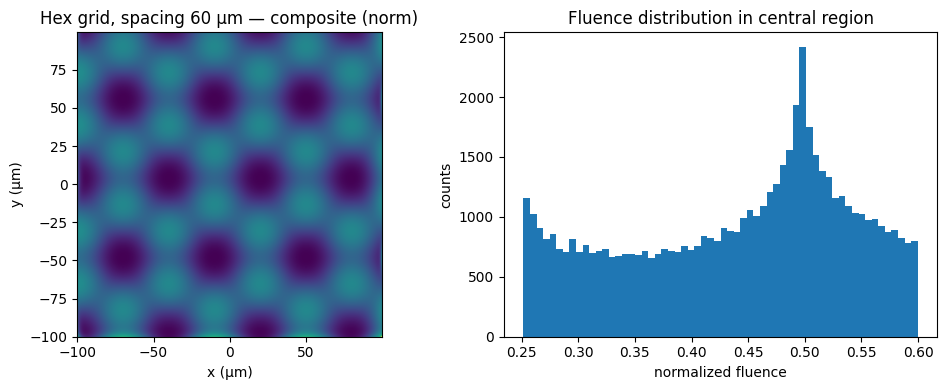


Numeric summary (lower CoV => better uniformity):

pattern  spacing     mean      std      cov
    hex       30 0.970461 0.011628 0.011982
 square       40 0.669346 0.013789 0.020601
 square       30 0.851001 0.022597 0.026554
    hex       40 0.731491 0.037613 0.051419
    hex       50 0.693446 0.063383 0.091403
 square       60 0.394000 0.063108 0.160173
 square       50 0.506634 0.083130 0.164084
    hex       60 0.440406 0.097502 0.221392


In [8]:
# Show composite maps for representative cases and histograms
for r in results:
    if r["spacing"] in (40, 60) and r["pattern"] == "hex":
        Icomp = r["Icomp"]
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].imshow(Icomp, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
        ax[0].set_title(f"{r['pattern'].capitalize()} grid, spacing {r['spacing']} µm — composite (norm)")
        ax[0].set_xlabel("x (µm)"); ax[0].set_ylabel("y (µm)")
        ax[1].hist(Icomp[(np.abs(X)<=60)&(np.abs(Y)<=60)].ravel(), bins=60)
        ax[1].set_title("Fluence distribution in central region")
        ax[1].set_xlabel("normalized fluence"); ax[1].set_ylabel("counts")
        plt.tight_layout()
        plt.show()

# Print numeric summary sorted by cov (lower = more uniform)
print("\nNumeric summary (lower CoV => better uniformity):\n")
print(df.sort_values("cov").to_string(index=False))